In [66]:
library(tidyverse)
library(leaps)
library(broom)
library(repr)
library(digest)
library(faraway)
library(mltools)
library(glmnet)
library(cowplot)
library(readxl)
library(GGally)
library(infer)
library(rsample)

In [69]:
data1<-read.csv("most_subscribed.csv")
head(data1, 3)

,rank,Youtuber,subscribers,video.views,video.count,category,started
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,1,T-Series,"222,000,000","198,459,090,822","17,317",Music,2006
2,2,YouTube Movies,"154,000,000",0,0,Film & Animation,2015
3,3,Cocomelon - Nursery Rhymes,"140,000,000","135,481,339,848",786,Education,2006


In [70]:
row_sub = apply(data1, 1, function(row) all(row !=0 ))
data1 <- data1[row_sub,]
data <- data1[data1$category %in% c("Gaming", "Music", "Entertainment", "People & Blogs"),]


In [73]:
data$subscribers<- as.numeric(gsub(",","",data$subscribers))
data$video.views<- as.numeric(gsub(",","",data$video.views))
data$video.count<- as.numeric(gsub(",","",data$video.count))



In [74]:
data<-data[,-c(0:1)]
head(data,3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,2.22e+08,198459090822,17317,Music,2006
6,1.11e+08,28469458228,4497,Gaming,2010
7,1.02e+08,16832456681,726,Entertainment,2012


In [75]:
#split data into test and training
split_data<-initial_split(data, prop=0.7, strata=video.views)
data_train<-training(split_data)
data_test<-testing(split_data)
head(data_train, 3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
176,26300000,3589276436,553,Gaming,2016
199,24700000,3060187306,1914,Entertainment,2017
219,23900000,3687600020,406,Entertainment,2015


In [76]:
full_interaction<-lm(video.views~video.count*subscribers+video.count*started+subscribers*started+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
with_interaction<-lm(video.views~video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
new_model<-lm(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)


In [77]:
#new model: think this is the model we should use: this has category interaction, and video.count*subscriber interaction
# it was seen in the summary for lm that the interaction is significant 
new_model<-lm(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category, data=data_train)
selection_model<-regsubsets(video.views~video.count*subscribers+video.count+subscribers+category+started+video.count*category+started*category+subscribers*category,
           data=data_train, 
           method="forward")
selection<-summary(selection_model)

data_summary_df <- tibble(
     n_input_variables = 1:8,
     RSQ = selection$rsq,
     RSS = selection$rss,
     ADJ.R2 = selection$adjr2,
     Cp = selection$cp,
     BIC = selection$bic,
 )
data_summary_df

n_input_variables,RSQ,RSS,ADJ.R2,Cp,BIC
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.6970299,2.163217e+22,0.6963907,146.33037,-556.0708
2,0.7178338,2.014676e+22,0.7166407,105.87179,-583.7670
3,0.7427172,1.837008e+22,0.7410819,57.08725,-621.5462
4,0.7561900,1.740811e+22,0.7541195,31.59066,-640.9832
5,0.7593411,1.718313e+22,0.7567809,27.15974,-641.0098
6,0.7620845,1.698725e+22,0.7590408,23.56072,-640.3017
7,0.7679194,1.657064e+22,0.7644481,13.65234,-645.9557
8,0.7706312,1.637701e+22,0.7667019,10.11781,-645.3850


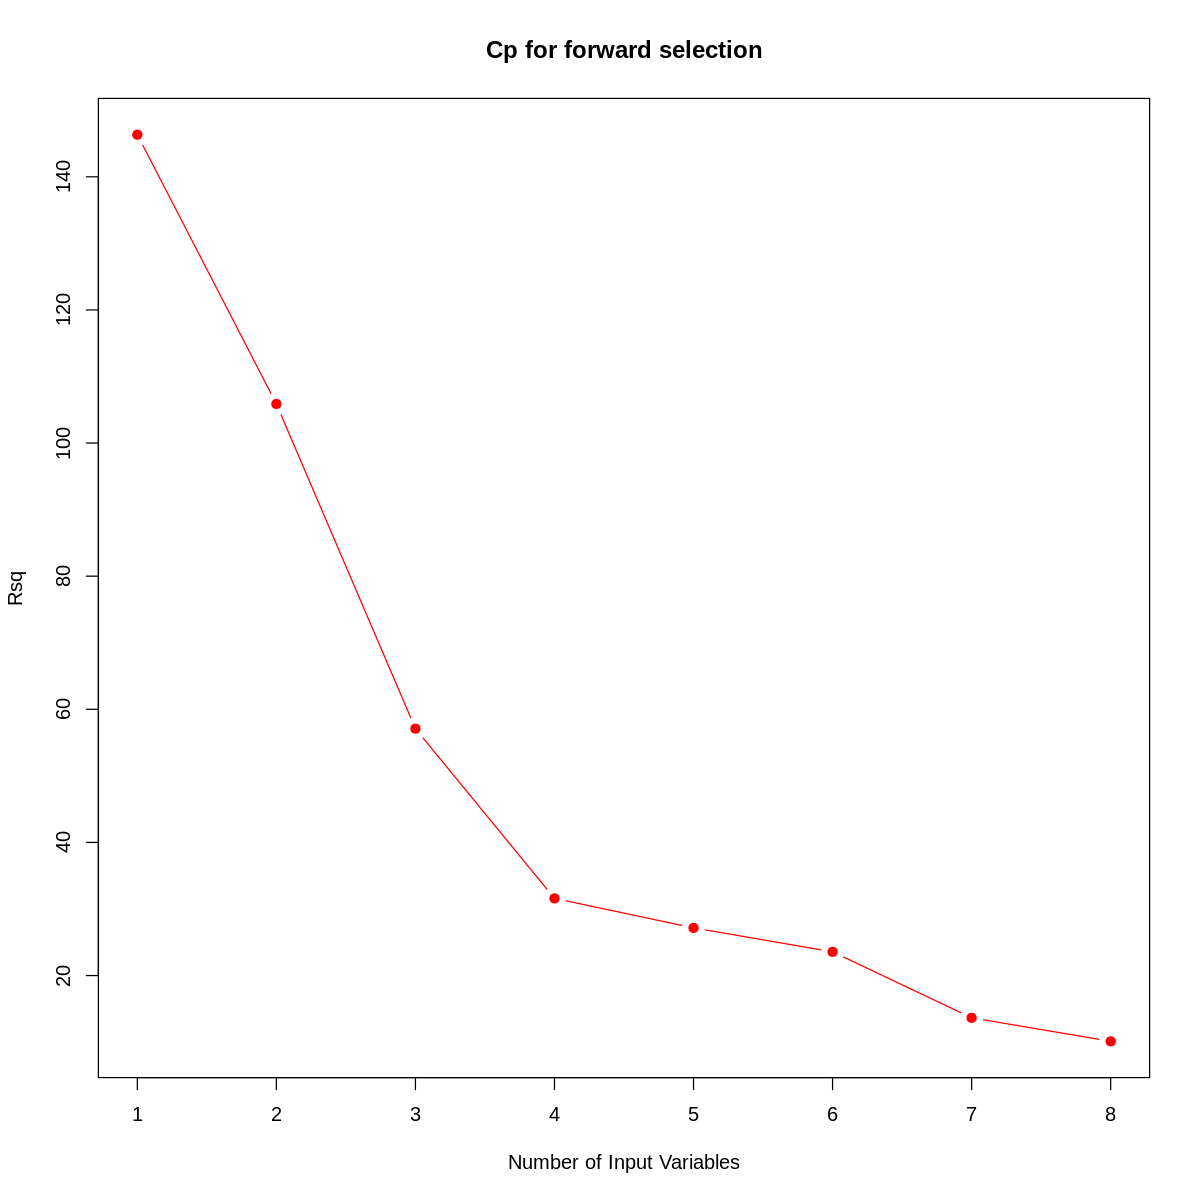

In [78]:
plot(summary(selection_model)$cp,
  main = "Cp for forward selection",
  xlab = "Number of Input Variables", ylab = "Rsq", type = "b", pch = 19,
  col = "red"
)

In [79]:
new_model_summary<-glance(new_model)%>% mutate_if(is.numeric, round, 3)
full_model_summary<-glance(full_interaction)%>% mutate_if(is.numeric, round, 3)
with_interaction_summary<-glance(with_interaction)%>% mutate_if(is.numeric, round, 3)
new_model_summary
full_model_summary
with_interaction_summary

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.775,0.767,5914795800,98.868,0,16,-11377.1,22790.21,22865.18,1.605803e+22,459,476


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.778,0.77,5884450842,89.167,0,18,-11373.62,22787.23,22870.54,1.582443e+22,457,476


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.76,0.752,6102277736,97.161,0,15,-11392.48,22818.95,22889.76,1.712939e+22,460,476


1. lowest cp with 8 params and best adj.r^2
2. consider including interaction plots
3. Can use f-stat as model diagnostic, comparing for different models, higher the better (more the model explains the variation) 

In [80]:
anova_1<-anova(new_model, full_interaction)
anova_2<-anova(new_model, with_interaction)
anova_3<-anova(full_interaction, with_interaction)
anova_1
anova_2
anova_3

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,459,1.605803e+22,NA,NA,NA,NA
2,457,1.582443e+22,2,2.335974e+20,3.373076,0.03513977


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,459,1.605803e+22,NA,NA,NA,NA
2,460,1.712939e+22,-1,-1.071358e+21,30.62351,5.27468e-08


,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,457,1.582443e+22,NA,NA,NA,NA
2,460,1.712939e+22,-3,-1.304955e+21,12.5621,6.623064e-08


In [12]:
prediction_model<-predict(new_model, newdata=data_test)
head(prediction_model, 3)

8          15          20 
69774680516 51411750615 45362640219

integer(0)

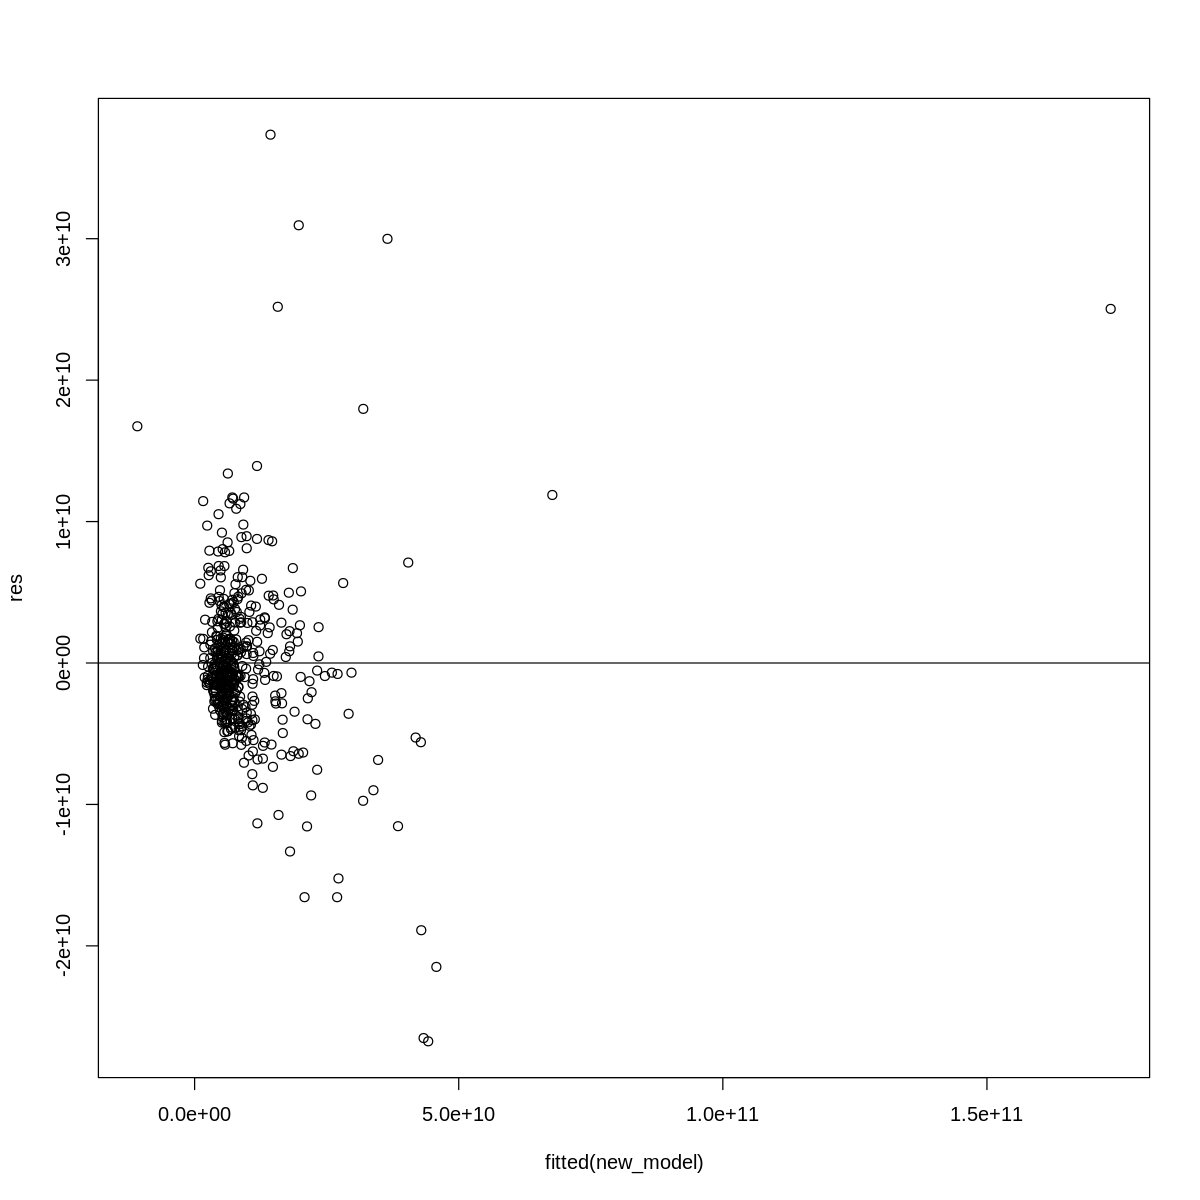

NULL

ERROR: Error in qqnorm(res) + qqline(res): non-numeric argument to binary operator


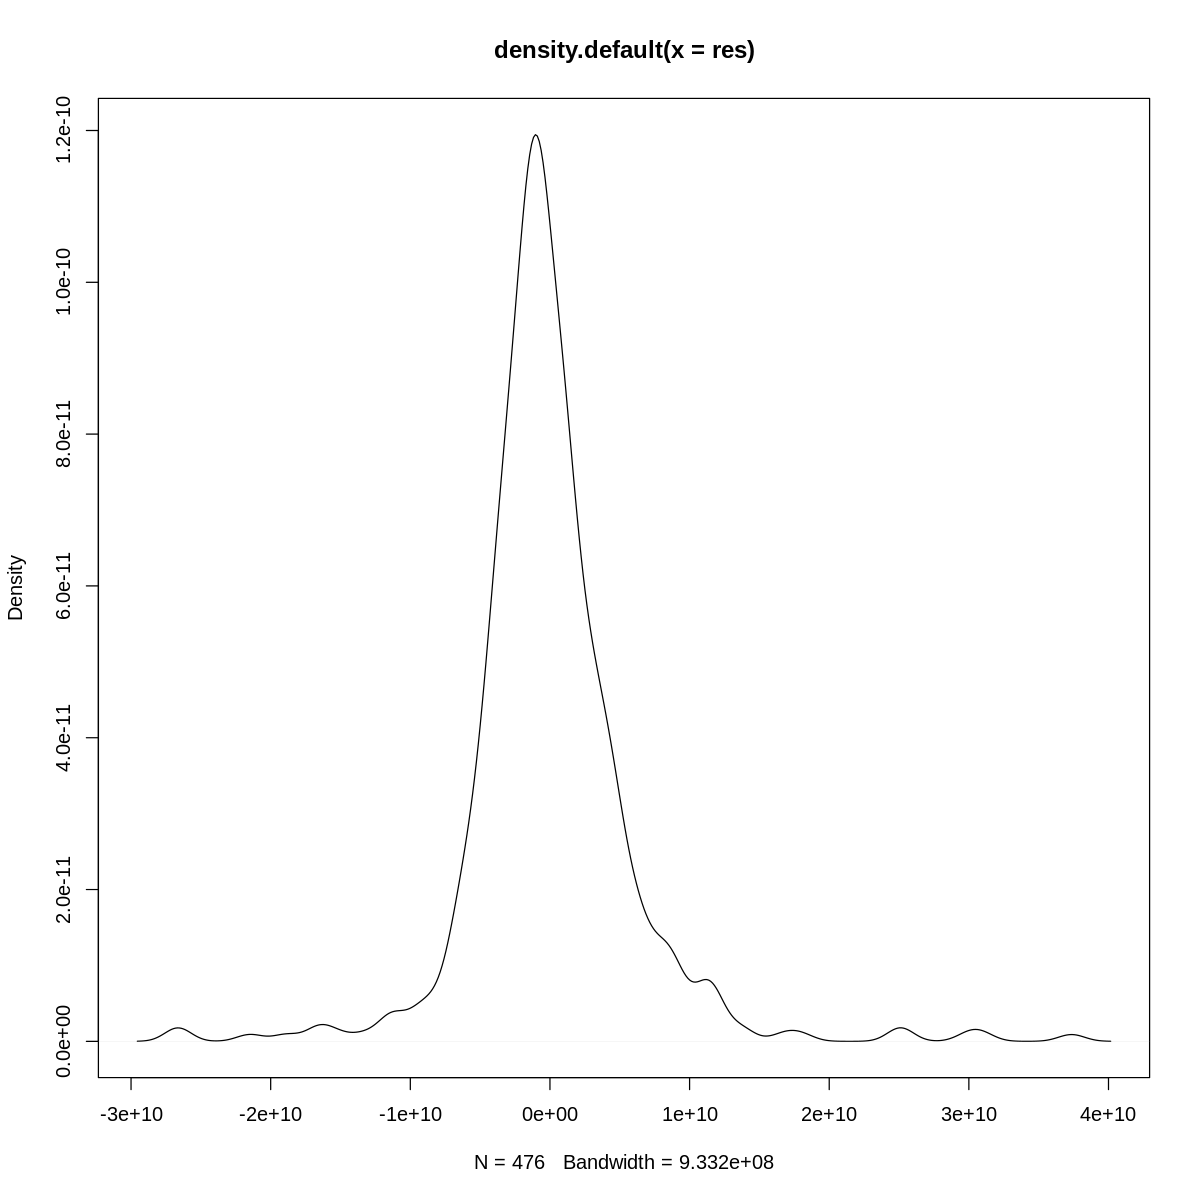

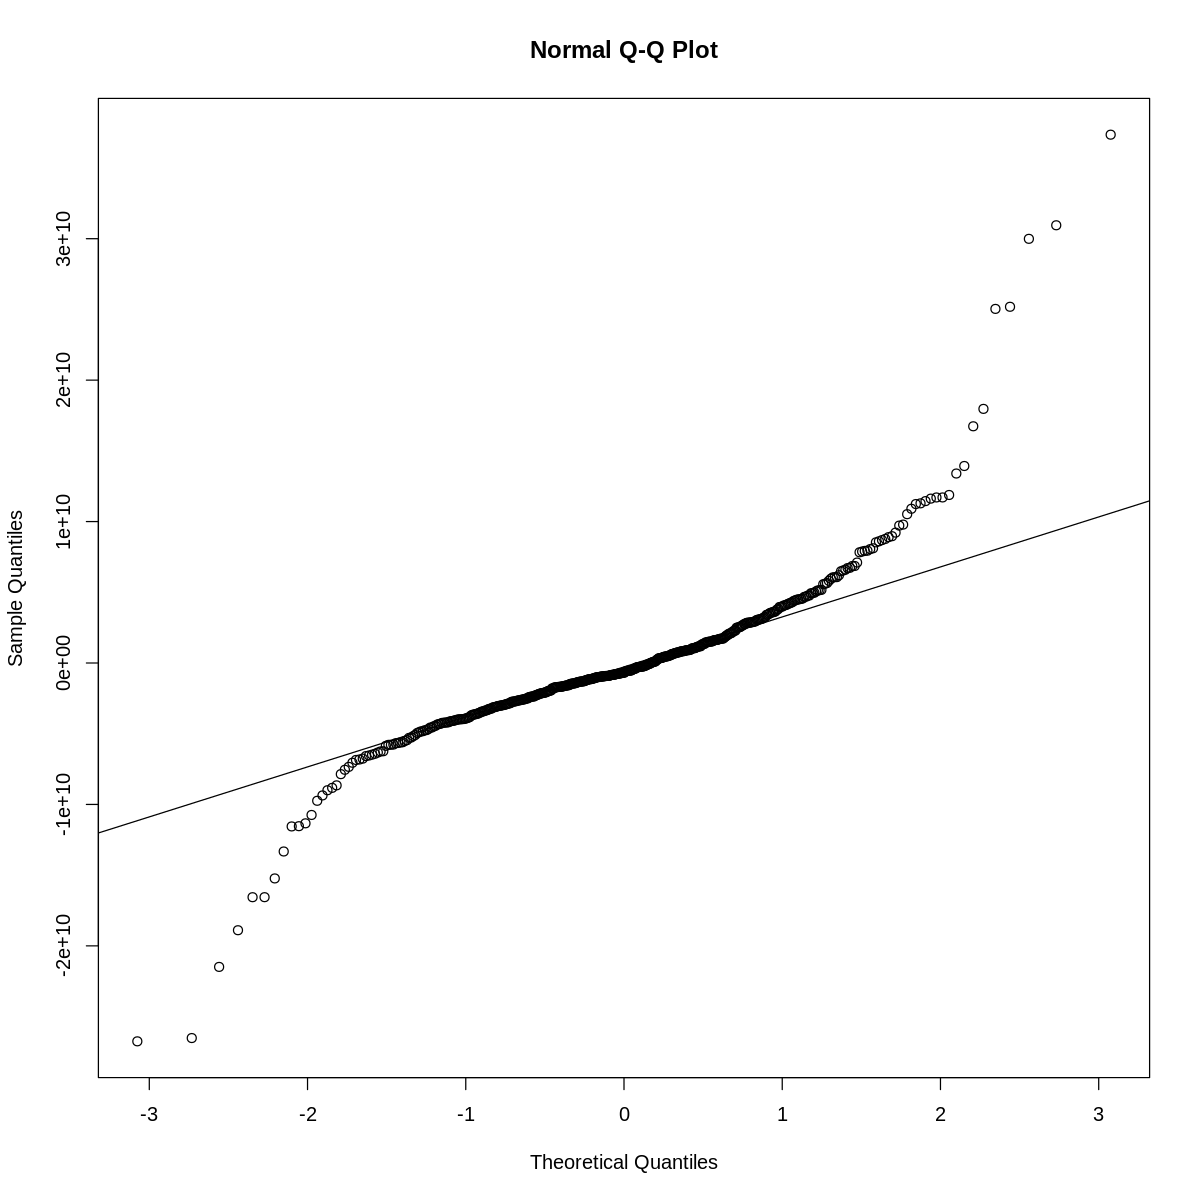

In [81]:
#residual plot
res<-resid(new_model)
resid_plot<-plot(fitted(new_model), res)+
    abline(0,0)
resid_plot
density_plot<-plot(density(res))
density_plot
qq_plot<-qqnorm(res)+
    qqline(res)
qq_lot


Assumptions: 
1. linearity: shows violation of Homoscedasticity (non-constant variance) 
2. Normally distributed residuals: from the qq plot we can see that the residuals near both tails do not follow a normal distribution, however, if we observe our density plot, we can see that the residuals appear relatively normally distributed (wiuth slight skewness) 

In [82]:
summary(data_train)

  subscribers         video.views         video.count         category        
 Min.   : 10900000   Min.   :4.391e+05   Min.   :     1.0   Length:476        
 1st Qu.: 12800000   1st Qu.:4.057e+09   1st Qu.:   328.8   Class :character  
 Median : 15150000   Median :6.681e+09   Median :   853.0   Mode  :character  
 Mean   : 19864076   Mean   :9.712e+09   Mean   :  7113.2                     
 3rd Qu.: 21925000   3rd Qu.:1.215e+10   3rd Qu.:  3137.2                     
 Max.   :222000000   Max.   :1.985e+11   Max.   :224455.0                     
    started    
 Min.   :2005  
 1st Qu.:2009  
 Median :2012  
 Mean   :2012  
 3rd Qu.:2015  
 Max.   :2021  

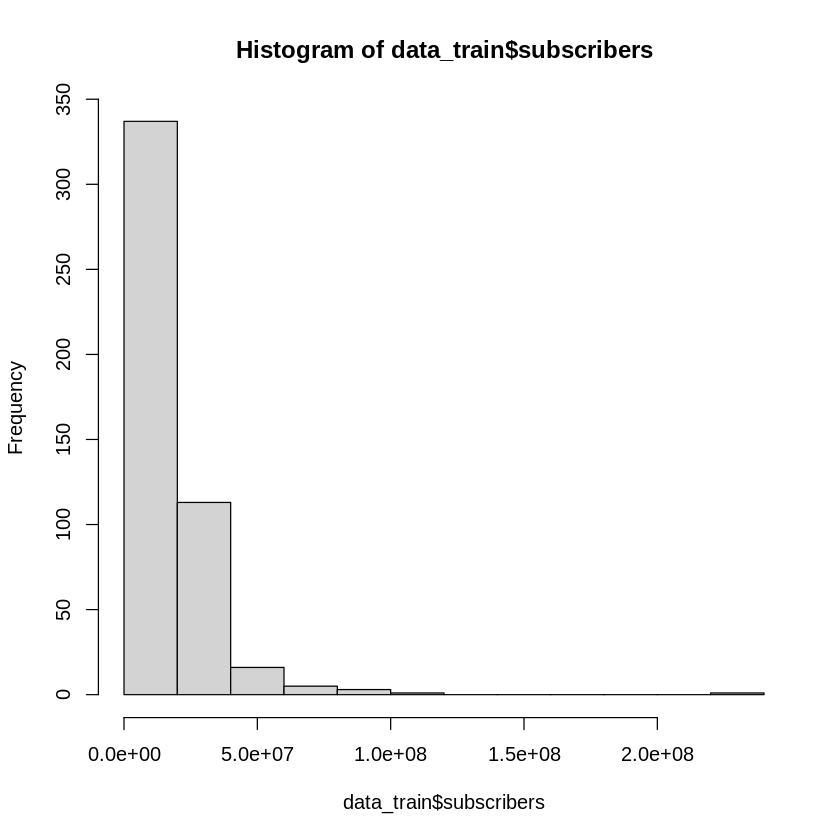

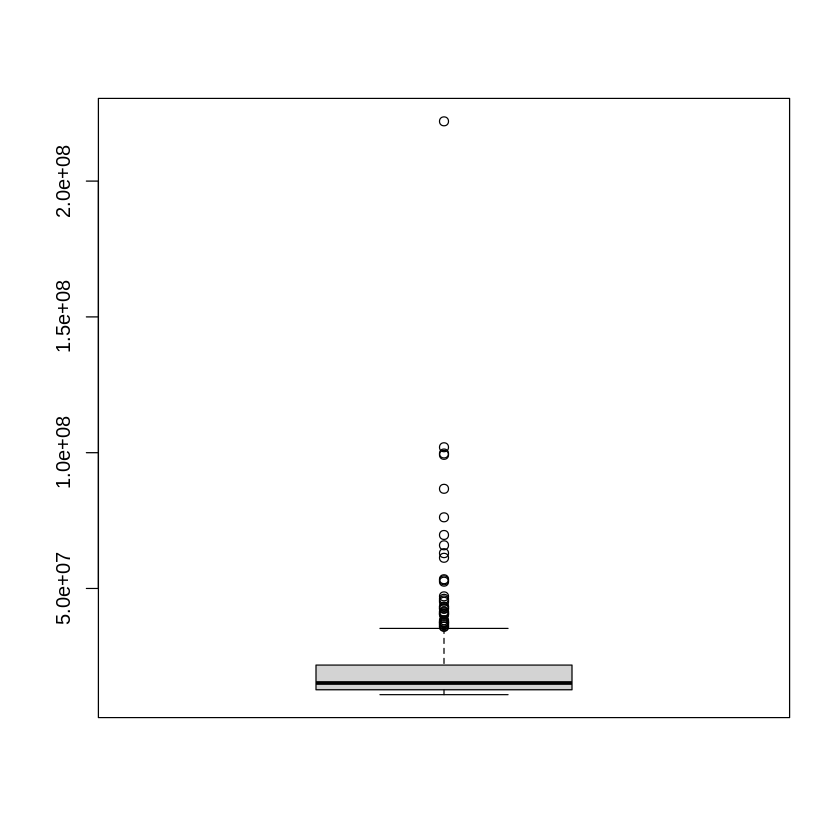

In [50]:
hist(data_train$subscribers)
boxplot(data_train$subscribers)



Topics to bring up: 
I think we should remove outliers, they could be leading to the non-normally distributed residuals and non-constant varaince, and thus leading to viiolations in the assumptions in regression... 
Note: actually, we should certainly remove the outliers from the data.... 
--> as we can see from the plot above, there is a clear outlier towards the right tail end of the data (and from boxplot)
--> if we want to remove them, refer to this page: https://statsandr.com/blog/outliers-detection-in-r/


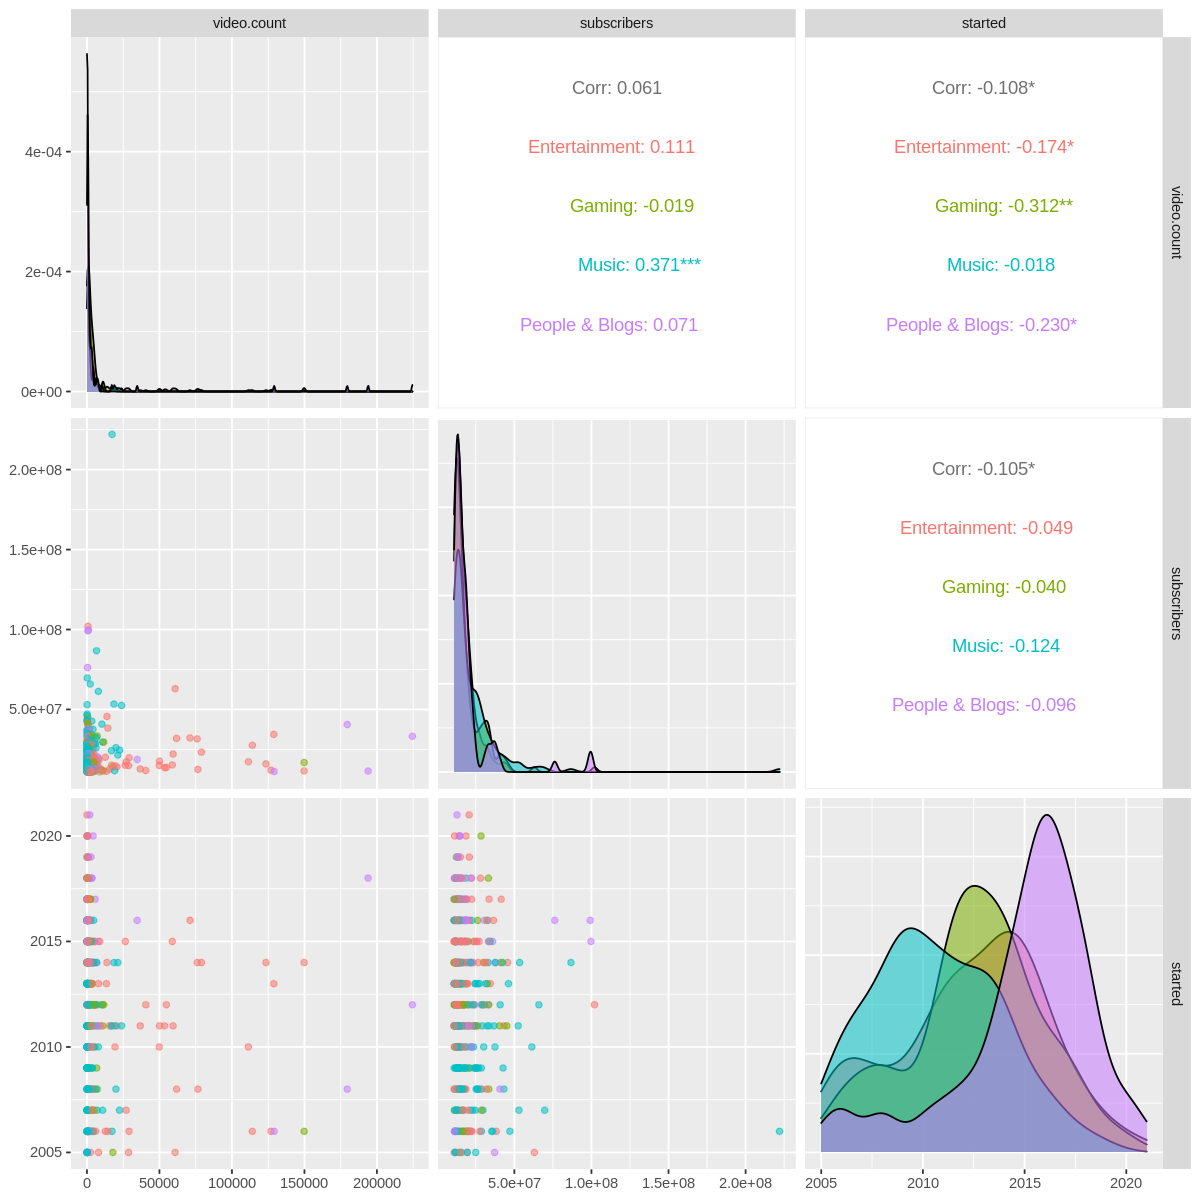

In [54]:
options(repr.plot.width = 10, repr.plot.height = 10)

plots<-data_train%>%
  select("video.count", "subscribers", "started") %>%
  ggpairs(mapping = aes(color = data_train$category, alpha = 0.5))
plots
#dont really know how useful this plot is to be honest, but included it anyways 

In [84]:
prediction_new_model<-new_model%>%
    predict(data_test)

rmse_new_model<-rmse(prediction_new_model, data_test$video.views)
rmse_new_model
#that is a terrible rmse, must mean we need to remove outliers to get better fit. 
#Thought: remove ou

[1] 5948223900

In [85]:
head(data_test, 3)

,subscribers,video.views,video.count,category,started
,<dbl>,<dbl>,<dbl>,<chr>,<int>
6,1.11e+08,28469458228,4497,Gaming,2010
9,9.92e+07,81963845811,702,People & Blogs,2016
12,8.67e+07,49067711243,6603,Music,2014
